In [2]:
import sys
import numpy as np
import cPickle
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class character_data_manager:
    """Your data butler"""
    def __init__(self,test_frac=.05,shuffle_scale=300,max_doc_loads=500,load_vec_flag=True):
        # Store parameters
        self.test_frac = test_frac
        self.shuffle_scale = shuffle_scale
        self.max_doc_loads = max_doc_loads
        self.load_vec_flag = load_vec_flag
        
        # Load in the document dictionary, query_list, and the entity lookups
        with open('document_dictionary.pkl','rb') as f:
            self.doc_dict = cPickle.load(f)
        with open('query_list.pkl','rb') as f:
            self.query_list = cPickle.load(f)
        with open('entity_vectors.pkl','rb') as f:
            self.ent_vecs = cPickle.load(f)
        with open('bad_entity_vectors.pkl','rb') as f:
            self.bEnt_vecs = cPickle.load(f)
                
        # Initialize a training schedule
        self.__loaded_docs = []
        self.__schedule_pos = 0
        self.__initialize_training_schedule__()
        
        
    def __initialize_training_schedule__(self):
        self.__schedule_pos = 0
        self.__weak_shuffle__()
    
    def __weak_shuffle__(self):
        list_len = len(self.query_list)
        def sortkey(x,obj):
            list_len = len(obj.query_list)
            x = x + np.random.normal(scale=obj.shuffle_scale)
            if x < 0:
                x = list_len - x
            if x > list_len:
                x = x - list_len
            return x
        
        # Give the data a random circular shift
        d = deque(self.query_list)
        d.rotate(np.random.randint(0,list_len))
        self.query_list = list(d)
        
        self.query_list =\
            [x for (y,x) in sorted( enumerate(self.query_list), key=lambda X: sortkey(X[0],self) )]    
    
    # We need a method to offer data. That's mostly what this is here for.
    def offer_data(self):
        """Used to pull a data/answer pair from the manager"""
        
        # Isolate the relevant query 
        query = self.query_list[self.__schedule_pos]
        
        # The data will be in the form of a vector sequence
        # So, we need to load and/or retreive this example's vector and tag sequences
        # Retreive the document vectors
        d_vec = self.__get_doc_vec__(query['doc'])
        # Retreive the query vectors
        q_vec = self.__get_query_vec__(query)
        # Combine them
        vecs = np.concatenate( (d_vec,q_vec) )
        # Retreive the tags
        tags = self.doc_dict[query['doc']]['tags'] + query['tags']
        
        # Store the vectors and tags so we can go right back to this point easily without re-loading
        self.__current_vecs = vecs
        self.__current_tags = tags
        self.__current_ans  = query['a']
        
        # Apply the permutation procedure, deal with particular words, and return the info!
        return self.permute_example()
    
    
    # For managing the rather large data
    def __get_doc_vec__(self,doc_name):
        if type(self.doc_dict[doc_name]['vecs']) != type(None):
            return self.doc_dict[doc_name]['vecs']
        
        else:
            # Load the document vectors in
            self.doc_dict[doc_name]['vecs'] = self.__get_vec__(self.doc_dict[doc_name])

            self.__loaded_docs += [doc_name]

            if len(self.__loaded_docs) > self.max_doc_loads:
                # Reset the "oldest" load
                self.doc_dict[self.__loaded_docs[0]]['vecs'] = None
                self.__loaded_docs = self.__loaded_docs[1:]
            
            return self.doc_dict[doc_name]['vecs']
    
    def __get_query_vec__(self,query):
        return self.__get_vec__(query)
        
    # The method for accessing vectors when we don't want to keep them in memory
    def __get_vec__(self,dic):
        if self.load_vec_flag:
            # Load pre-computed vectors
            with open(dic['loc'],'rb') as f:
                return cPickle.load(f)
            
        else:
            # Use spacy to compute vectors
            # NOTE: THIS IS MUCH SLOWER !!!
            return np.array([ t.vector for t in nlp(dic['text']) ])
        
            
    # For permuting entities that ought not be memorized
    def permute_example(self):
        # Randomly permute good entities
        e_perm = np.random.permutation( np.arange(1,self.ent_vecs.shape[0]) )
        # And also bad entities
        b_perm = np.random.permutation( np.arange(0,self.bEnt_vecs.shape[0]) )
        
        # Create a copy of the vectors
        V = self.__current_vecs.copy()
        
        # Go through each token and make any final changes that are necessary
        for i,t in enumerate(self.__current_tags):
            if t:
                if t[0] == 0:
                    # An unknown word
                    V[i,:] = self.unknown_vec()
                if t[0] == 3:
                    # A query start indicator
                    V[i,:] = self.query_start_vec()
                if t[0] == 4:
                    # A blank (like, clue to the answer) indicator
                    V[i,:] = self.ent_vecs[0,:]
                if t[0] == 1:
                    # An entity. Give it it's randomly assigned vector
                    V[i,:] = self.ent_vecs[e_perm[t[1]],:]
                if t[0] == 2:
                    # A bad entity. Give it it's randomly assigned vector
                    V[i,:] = self.bEnt_vecs[b_perm[t[1]],:]
                    
        # Return the resulting vector-sequence+answer pair
        return V, e_perm[self.__current_ans]
    
    # For moving through the data
    def advance_schedule(self):
        self.__schedule_pos += 1
        if self.__schedule_pos > len(self.query_list):
            self.__initialize_training_schedule__()
            
            
    # Vectors for things we have to make up
    def unknown_vec(self):
        return np.zeros(300).astype('float32')
    
    def query_start_vec(self):
        O = np.ones(300).astype('float32')
        return O / np.sqrt(300.)
    
    
    # For getting to know your butler
    def num_loaded(self):
        return len(self.__loaded_docs)
    
    def loaded_docs(self):
        return self.__loaded_docs[:]
    
    def vec_memory_footprint(self):
        D = 0
        for k,v in butler_loader.doc_dict.iteritems():
            try:
                nB = v['vecs'].nbytes
            except:
                nB = sys.getsizeof(v['vecs'])
            D += nB
        return D / 1e6
    

In [13]:
data_butler = character_data_manager()

In [14]:
import time
dur = np.zeros(40)
for r in range(len(dur)):
    t = time.time()
    for i in range(50):
        data_butler.offer_data()
        data_butler.advance_schedule()
    dur[r] = time.time() - t
    print dur[r]
    sys.stdout.flush()

14.0762941837
6.59964895248
4.51137518883
3.23519682884
2.49084806442
2.50559711456
1.64195990562
2.7319149971
3.52864909172
2.06762099266
1.72249007225
1.31656289101
1.92740607262
3.75150990486
2.9634912014
1.28107595444
3.49779701233
1.82039690018
5.78261899948
2.05041790009
1.36055397987
1.44436812401
1.76444602013
2.04227685928
2.65708088875
2.20244193077
3.66636109352
1.38426995277
1.36053490639
1.71263599396
2.17617988586
4.10039901733
3.16092920303
1.33740305901
2.0551469326
2.35719490051
2.0707628727
3.57872891426
1.2791800499
1.9383020401


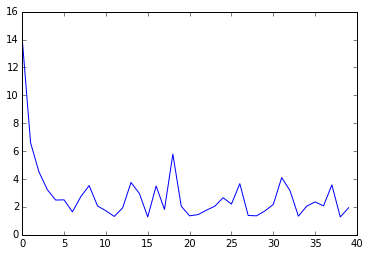

In [16]:
plt.figure();
ax = plt.axes();
ax.plot( dur );

In [18]:
np.mean(dur[10:])/50

0.046508642355600989